# 디렉토리 설정 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/Repositary/MRI_classification/utils/init.py' ./

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260005.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260006.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260007.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260008.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260009.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260010.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260011.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260012.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260013.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260014.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260015.jpg  
  inflating: KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8/0603421260016.jpg  
  inflating: KYR_B_imaging/20201224 DL_M

In [ ]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

# 초기작업
- 데이터 제너레이터에 넣을 수 있는 기본형태를 만드는 것 

## 기본 DF 생성 
- csv 데이터인 snsb_df 
- 이미지 디렉토리 관련인 dir_df만듬 

전처리 과정에서 
- snsb_df -> csvs 
- dir_df -> new_dir_df로 변환 함 


In [ ]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 
import warnings
warnings.filterwarnings('ignore')
from albumentations import (
    Rotate,Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,JpegCompression
)

###snsb_df 생성 
- 환자 정보 데이터 프레임 

In [ ]:
columns = ['성명',
 '병록번호',
 '만나이',
 '검사일',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x))) #소수점으로 되어 있는 것 처리하고 str형 변형 

snsb_df = snsb_df[columns]

## 결측치 처리 

#컬럼 중 isnull 검색 
#검색한 표본들의 평균 나이 
#평균 나이로 원래  csvs 검색 
#해당 나이로 검색 된 것들의 평균 값으로 insull 채움 

null_columns = ['RCFT_immediate_recall_z',
                'SVLT_recall_total_score_z',
                'SVLT_Delayed_recall_z',
                'SVLT_recognition_score_z',
'RCFT_delayed_recall_z',            
'RCFT_recognition_score_z',        
'K_MMSE_total_score_z',           
'SNSB_II_Domain_Attention_z',       
'SNSB_II_Domain_Language_z',        
'SNSB_II_Domain_Visuospatial_z',    
'SNSB_II_Domain_Memory_z',          
'SNSB_II_Domain_Frontal_z']         

for null_column in null_columns:
  try:
    null_age = int(np.mean(snsb_df[snsb_df[null_column].isnull()]['만나이']))
    null_value = np.mean(snsb_df[snsb_df['만나이']==null_age][null_column].dropna())
    snsb_df.loc[snsb_df[null_column].isnull(),null_column] = null_value
  except:
    pass

###dir_df 생성 
- 환자  별 mri 디렉토리 데이터 프레임 
- 이미지 장수 정리 안된 데이터 프레임 

In [ ]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')
dir_df = init.dir_df(folder_dir)
dir_df = dir_df.sort_values(by=['key','dir'])
dir_df = dir_df.reset_index().drop(columns = 'index')

### 병록번호- key 값 보정
- 병록번호 == key 하게 만들어야 함 -> primary key 
- 중복 제거, @@@-1 형태 제거, 9자리로 통일 

In [ ]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

dir_df,snsb_df = init.key_mismatch(dir_df,snsb_df,target_length)
#인덱스 초기화 
dir_df = dir_df.reset_index().drop(columns = 'index')
# plt.hist(snsb_df['병록번호'].map(len))
# plt.show()

#에러값들 제외 
errors = ['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']

dir_df = dir_df.drop(np.where(dir_df['key'].map(len)>9)[0])

## new_dir_df 생성 - 이미지 장수 통일 
- 위에서 만든 dir_df에서 각 key 별로 이미지 19장으로 맞춤 
- 19장으로 맞추는 이유는 가장 비율이 높아서 


### key 값 별 이미지 장수 연산 

In [ ]:
#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: init.check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
# images_length.value_counts()

length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
# length_df_less = length_df[length_df['image_length']<standard]

len(length_df_over)

1606

### key값 별로 이미지 19장 있는 new_dir_df 생성 

In [ ]:
new_dir_df = pd.DataFrame(np.zeros(len(length_df_over)*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

for index in tqdm(range(len(length_df_over))):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard=19)]
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

100%|██████████| 1606/1606 [00:07<00:00, 214.45it/s]


## csvs 생성 
 - 중복 제거 
 - z score -1.0를 기준으로 0(정상) 1(비정상)으로 분류 



In [ ]:
#19장의 사진으로 추린 new_dir_df로 새로운 키 리스트만듬) 

key_lists = np.unique(new_dir_df['key'])
key_lists.sort()

Embedding_columns = snsb_df.columns[5:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key','dir'])

#snsb_df 중 key_lists에 있는 행들만 추림 -> csvs 
csvs = snsb_df[snsb_df['병록번호'].apply(lambda x : x in key_lists)].sort_values(by=['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')

#중복 제거 : 이름으로 정렬 후 중복 제거 
csvs = csvs.sort_values(by=['성명'])
csvs = csvs.drop_duplicates(['병록번호'], keep = 'first')

#다시 병록번호 로 정렬 해서 csvs 와 new_dir_df 순을 맞춤 
csvs = csvs.sort_values(['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

#맞춤 확인 
print(len(csvs),len(np.unique(new_dir_df['key'])))


1606 1606


# 전처리

## 이미지 전처리

In [ ]:
#key_lists -> train_keys -> batch_keys -> key -> dirs_of_key -> images -> batch_images 
def key_to_dir(key,new_dir_df): #key -> dir_of_key 
  dir_of_key = new_dir_df[new_dir_df['key']==key]
  return dir_of_key
  
def read_imgs(img_dir_df,augmentation): #224, 224, 19 용 #dir_of_key -> images 
  temp_imgs = np.zeros(image_size*image_size*image_channels).reshape(image_size,image_size,image_channels)
  random_seed = np.random.randint(-20,20)/100
  for i in range(len(img_dir_df)):
    temp_img = img_dir_df['dir'].iloc[i]
    temp_img = img_preprocess(cv2.imread(temp_img),augmentation,random_seed)
    temp_imgs[:,:,i] = temp_img 
  return temp_imgs

#이미지 전처리 
def img_preprocess(img,augmentation,seed): 
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  if augmentation:
      preprocessed_img = random_contrast_brightness(preprocessed_img,seed)
  preprocessed_img = cv2.cvtColor(preprocessed_img,cv2.COLOR_BGR2GRAY)
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  preprocessed_img = preprocessed_img/255.
  return preprocessed_img 

#Augmentation, Seed를 받아서 동일하게 적용하게 끔 함 
def random_contrast_brightness(temp_img,random_seed):
    aug_img = tf.image.adjust_contrast(temp_img,random_seed)
    aug_img = tf.image.adjust_brightness(aug_img,random_seed)
    return np.array(aug_img)

# 데이터 제너레이터

## 사전설정

In [ ]:
input_columns = ['만나이','교육년수']
output_columns = ['E_SVLT_recall_total_score_z', 'E_SVLT_Delayed_recall_z',
       'E_SVLT_recognition_score_z', 'E_RCFT_immediate_recall_z',
       'E_RCFT_delayed_recall_z', 'E_RCFT_recognition_score_z',
       'E_K_MMSE_total_score_z', 'E_SNSB_II_Domain_Attention_z',
       'E_SNSB_II_Domain_Language_z', 'E_SNSB_II_Domain_Visuospatial_z',
       'E_SNSB_II_Domain_Memory_z', 'E_SNSB_II_Domain_Frontal_z']
output_column = 'SVLT_recall_total_score_z'


image_size = 256
image_channels = 19 
BATCH_SIZE= 32

## !!!제너레이터

키 리스트를 이용해 train, valid, test 분리 

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math


class DataGenerator(Sequence):
  def __init__(self,
                 new_dir_df,
                 csvs,
                 batch_key_lists,
                 output_column,
                 batch_size: int,
                 augmentation: bool = False,
                 shuffle: bool = False,
                 rescale:bool = True) -> None:
        self.input_columns = input_columns 
        self.key_lists = batch_key_lists
        self.output_column = output_column
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.new_dir_df = new_dir_df
        self.csvs = csvs

  def __len__(self):
    return len(self.key_lists) // self.batch_size

  def batch_csv_in_out(self,key):
      batch_csvs = self.csvs.loc[self.csvs['병록번호']==key]
      input_values = batch_csvs[self.input_columns]
      output_values = batch_csvs[self.output_column]
      return input_values,output_values
  
  #바깥에서 만든 min,max,std,mean 값으로 scaling 진행 
  def minmax_scaling(self,input_csvs,output_csvs):
    global csvs_input_min, csvs_input_min,csvs_output_min,csvs_output_max
    input_csvs = (input_csvs-csvs_input_min)/(csvs_input_max-csvs_input_min)
    output_csvs = (output_csvs-csvs_output_min)/(csvs_output_max-csvs_output_min)
    return input_csvs,output_csvs


  def __getitem__(self, index):
    batch_index= np.arange(index*self.batch_size,(index+1)*self.batch_size)
    self.batch_keys = self.key_lists[batch_index]

    #imgs 
    temp_imgs = []
    input_csvs = []
    output_csvs = [] 
    for key in range(len(self.batch_keys)):
        #image 
        img_dir_df = key_to_dir(self.batch_keys[key],self.new_dir_df)
        temp_img = read_imgs(img_dir_df,self.augmentation)
        temp_imgs.append(temp_img)
        #csvs
        input_values,output_values = self.batch_csv_in_out(self.batch_keys[key])
        input_csvs.append(input_values)
        output_csvs.append(output_values)
      
    input_imgs = np.array(temp_imgs).astype(np.float)
    input_csvs = np.array(input_csvs).reshape(-1,len(self.input_columns))
    output_csvs= np.array(output_csvs).reshape(-1).astype(np.float)

    input_csvs,output_csvs = self.minmax_scaling(input_csvs,output_csvs)
    return [input_imgs,input_csvs],output_csvs
    # return input_imgs,output_csvs

#모델

In [ ]:
import tensorflow as tf
from tensorflow import keras 
from keras import backend as K
from keras import optimizers,Model,layers,utils,optimizers
from keras.metrics import Recall
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from keras.layers import Activation
from keras.layers import BatchNormalization,Conv2D,Dropout,Dense,Flatten,Input
from keras.layers import Reshape
from keras.layers import concatenate

from tensorflow.keras.applications import  VGG19,EfficientNetV2S, ResNet50V2, vgg19,resnet_v2,efficientnet_v2   
from keras.layers.pooling import GlobalAveragePooling2D,MaxPooling2D
from keras.callbacks import LearningRateScheduler


## 콜백

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
n=0
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):
    global n 

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])
    print(f'현 회차 : {n}')

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    f'best_model_{n}.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=35)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [ plot_losses,model_check_point,early_stopping]

## !!!모델 사전 정의

In [ ]:
res50 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
res50.trainable = False

vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
vgg_19.trainable = False

effv2 = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
effv2.trainable = False

In [ ]:
def input_to_pre(image_input): #224,224,19
  x = Conv2D(16, (2,2), padding ='same',activation = 'relu')(image_input)
  x = Dropout(0.2)(x)
  out = Conv2D(3, (2,2), padding ='same',activation = 'relu')(x)
  return out 

def image_encoder_layer(filters,img_input):
  img = Conv2D(filters,(3,3),padding='same')(img_input)
  img = Dropout(0.2)(img)
  img_output = BatchNormalization()(img)
  return img_output

def image_encoder(image):
  img_out = image_encoder_layer(128,image)
  return img_out

def csvs_layers(filters,csv_input):
  csv = Dense(filters, activation = 'relu')(csv_input)
  csv = Dropout(0.2)(csv)
  csv_layer_out = BatchNormalization()(csv)
  return csv_layer_out

def csvs_decoder(csvs_input):
  csvs_out = csvs_layers(128,csvs_input)
  return csvs_out

## !!!모델 

In [ ]:
#image input 
def make_model():
  image_input = Input((image_size,image_size,19))
  image = input_to_pre(image_input)

  # conv 
  res = resnet_v2.preprocess_input(image)
  res = res50(res)
  res = image_encoder(res)

  vgg = vgg19.preprocess_input(image)
  vgg = vgg_19(vgg)
  vgg = image_encoder(vgg)

  eff = efficientnet_v2.preprocess_input(image)
  eff = effv2(eff)
  eff = image_encoder(eff)

  # image combined 
  image_combined = concatenate([res,vgg,eff])
  image_combined = Conv2D(128, (2,2), padding = 'same')(image_combined)
  image_out = GlobalAveragePooling2D()(image_combined)
  
  #csv 
  csvs_input = Input((2))
  csvs_out = csvs_decoder(csvs_input)


  #image csv combined 
  combined = concatenate([image_out,csvs_out])

  #out 
  out = Dense(1,activation='sigmoid')(combined)

  model = Model([image_input,csvs_input],out)
  return model


## !!!Compile - Train

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

In [ ]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

## Cross validation

In [ ]:
output_column = 'SVLT_recall_total_score_z'

input_columns = ['만나이','교육년수']

def minmax(index,column):
  scaling_value = np.array(csvs[column].iloc[index])
  min = np.min(scaling_value,axis=0)
  max = np.max(scaling_value,axis=0)
  return min,max

In [ ]:
model_lists = []
history_lists = []
fold_lists = {}

#Stratified Kfold indexing 용 
test_index = np.arange(1446,1606)
key_indexes = np.arange(1445) #Train, Valid Index 
y = np.array(csvs['E_'+output_column][:1445])

#Stratified Kfold 
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5,shuffle=True, random_state= 42)
for n,[train_index, valid_index] in enumerate(skf.split(key_indexes, y)):
  if n ==2:

    #minmax scaling 용 0
    csvs_input_min, csvs_input_max = minmax(train_index,input_columns)
    csvs_output_min, csvs_output_max = minmax(train_index,output_column)
    #Predict 용 값 저장 
    fold_lists[n] = {'input':[csvs_input_min,csvs_input_max],
                     'output':[csvs_output_min,csvs_output_max],
                    'index':[train_index,valid_index]}
    
    #제너레이터 
    train_generator = DataGenerator(new_dir_df,
                                  csvs,
                                  key_lists[train_index],
                                  output_column,
                                  batch_size=BATCH_SIZE,
                                  augmentation=True,
                                    shuffle=True)
    valid_generator = DataGenerator(new_dir_df,
                                  csvs,
                                  key_lists[valid_index],
                                  output_column,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)
    test_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[test_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
    model = make_model()
    model.compile(optimizer=optimizer,loss = 'mse')
    history = model.fit(train_generator,validation_data = valid_generator, epochs=50,verbose=1,callbacks=callbacks)
    
    model_lists.append(model)
    history_lists.append(history)
    
    #21시 30분 시작 
    #15시30분 종료 예정 

Epoch 1/50
 6/37 [===>..........................] - ETA: 3:01 - loss: 0.0457

UnknownError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(len(model_lists)):
  model = model_lists
  model.save(f'Ex_{i}.h5')

In [ ]:
plt.plot(history_lists[0].history['loss'][5:40])
plt.plot(history_lists[0].history['val_loss'][5:40])
plt.show()

IndexError: ignored

In [ ]:
best_model = keras.models.load_model('/content/best_model_0.h5')

# 평가

In [ ]:
csvs_input_min,csvs_input_max = fold_lists[n]['input']
csvs_output_min,csvs_output_max = fold_lists[n]['output']
train_index, valid_index = fold_lists[n]['index']

train_generator = DataGenerator(new_dir_df,
                              csvs,
                              key_lists[train_index],
                              output_column,
                              batch_size=BATCH_SIZE,
                              augmentation=True,
                                shuffle=True)

y_ = best_model.predict(train_generator)
predicted = y_*(csvs_output_max-csvs_output_min)+csvs_output_min
predicted = predicted.squeeze()



In [ ]:
y_true = csvs.iloc[train_index][:1152]['E_'+output_column].values
y_true_normal = np.where(y_true==0)[0]
y_true_anormal = np.where(y_true==1)[0]

(array([ 17.,   3.,   6.,  11., 107., 109.,  65.,  63., 187.,  82.]),
 array([-2.1438293 , -2.008331  , -1.8728329 , -1.7373346 , -1.6018364 ,
        -1.4663382 , -1.3308399 , -1.1953417 , -1.0598434 , -0.9243452 ,
        -0.78884697], dtype=float32),
 <a list of 10 Patch objects>)

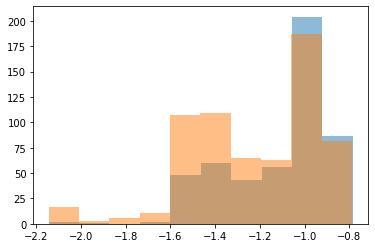

In [ ]:
plt.hist(predicted[y_true_normal],alpha=0.5)
plt.hist(predicted[y_true_anormal],alpha=0.5)